In [5]:
import numpy as np
import pickle
import torch
from torch.distributions.uniform import Uniform

import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
plt.rcParams.update({'font.size': 18})

from WassersteinDistance import OneDimMonotoneWasserstein, OneDimEmpWasserstein, OneDimMonotonePushForward
from PolyModel import LegendrePolyModel

# convert to double
torch.set_default_tensor_type(torch.DoubleTensor)

### Test optimization

Wp distance: 0.111803
Wp distance: 0.018634
Wp distance: 0.006988


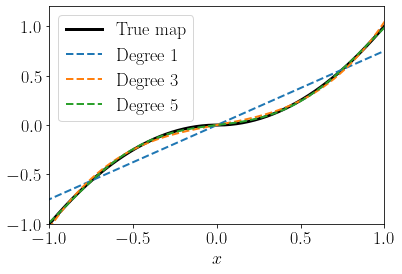

In [6]:
# define reference
eta = Uniform(torch.tensor([-1.0]), torch.tensor([1.0]))

# define true map and push-forward
k     = 1
Ttrue = lambda x: x**(2*k) * np.sign(x) 
nu    = OneDimMonotonePushForward(Ttrue, eta)

# define objective parameters
N = 1000
p = 2

# plot the true and approximate maps
xx = torch.linspace(-1.2,1.2,400).view(-1,1)

plt.figure()
plt.plot(xx, Ttrue(xx), linewidth=3, linestyle='-',color='k', label='True map')

for order in [1,3,5]:#5,10]:
    
    # define model
    FL = LegendrePolyModel(order)

    # define and minimize objective
    objective = OneDimMonotoneWasserstein(nu, FL, eta, N, p)
    objective.optimize()    
    print('Wp distance: %f' % objective.forward())
    
    # plot approximate map
    Tapprox_xx = FL(xx[:,0]).detach().numpy()
    plt.plot(xx, Tapprox_xx, linewidth=2, linestyle='--', label='Degree '+str(order))

plt.xlim(-1,1)
plt.ylim(-1.0,1.2)
plt.xlabel('$x$')
plt.legend(loc='upper left')
plt.savefig('figures/Wasserstein2_compact_map_poly.pdf', bbox_inches="tight")

### Map convergence study

In [9]:
# define reference
eta = Uniform(torch.tensor([-1.0]), torch.tensor([1.0]))

# generate test points for empirical CDF
Ntest_samples = 1000000
xtest = eta.sample((Ntest_samples,))

# evaluate true map at test points
Ttrue_xx = nu.icdf(eta.cdf(xtest))
print(Ttrue_xx.shape)

torch.Size([1000000, 1])


In [10]:
# fix seed
np.random.seed(2)
torch.manual_seed(1)

# set parameters
Ntrain        = 10000
Ntest         = 10000
k_vect        = [1,2,3,4]
orders        = np.logspace(0,3,10,dtype=int)
Wp_loss       = np.zeros((len(k_vect), len(orders)))
Wp_emp        = np.zeros((len(k_vect), len(orders)))
L2_test_error = np.zeros((len(k_vect), len(orders)))
mon_percent   = np.zeros((len(k_vect), len(orders)))
min_gradient  = np.zeros((len(k_vect), len(orders)))

# set p
p = 2

# define objective for computing distance
Wp_check = OneDimEmpWasserstein(N=Ntest)

# define two sets of test points to check monotonicity
xtest_p1 = eta.sample((Ntest,))
xtest_p2 = eta.sample((Ntest,))

for (j,k) in enumerate(k_vect):
    
    # define true map and push-forward
    spl = lambda x: x**(2*k) * np.sign(x) 
    nu  = OneDimMonotonePushForward(spl, eta)
    
    # run map optimization
    for (i,order) in enumerate(orders):
        print((k,order))
        
        # define model
        F = LegendrePolyModel(order)
        
        # define and minimize objective
        objective = OneDimMonotoneWasserstein(nu, F, eta, N=Ntrain, p=2)
        objective.optimize()

        # evaluate map
        F.eval()
        Fx = F(xtest[:,0])
        
        # measure map error and monotonicity
        Wp_loss[j,i]       = objective.forward()
        Wp_emp[j,i]        = Wp_check.forward(nu, Fx, p)
        L2_test_error[j,i] = ((torch.tensor(spl(xtest)) - Fx).pow(2).mean().item())**(1./2)
        mon_percent[j,i]   = torch.mean(((F(xtest_p1[:,0]) - F(xtest_p2[:,0])) * (xtest_p1 - xtest_p2) > 0.0)*1.0).item()        

(1, 1)


<ipython-input-10-54f9645844c1>:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  L2_test_error[j,i] = ((torch.tensor(spl(xtest)) - Fx).pow(2).mean().item())**(1./2)


(1, 2)
(1, 4)
(1, 10)
(1, 21)
(1, 46)
(1, 100)
(1, 215)
(1, 464)
(1, 1000)
(2, 1)
(2, 2)
(2, 4)
(2, 10)
(2, 21)
(2, 46)
(2, 100)
(2, 215)
(2, 464)
(2, 1000)
(3, 1)
(3, 2)
(3, 4)
(3, 10)
(3, 21)
(3, 46)
(3, 100)
(3, 215)
(3, 464)
(3, 1000)
(4, 1)
(4, 2)
(4, 4)
(4, 10)
(4, 21)
(4, 46)
(4, 100)
(4, 215)
(4, 464)
(4, 1000)


### Check map

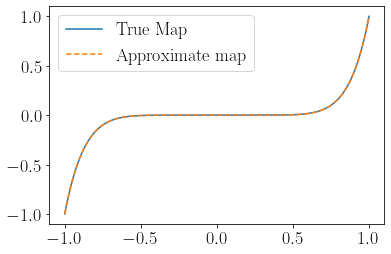

In [11]:
xx = torch.linspace(-1.,1.,1000)
yy = (F.forward(xx).detach().numpy())

plt.figure()
plt.plot(xx,spl(xx),label='True Map')
plt.plot(xx,yy,'--',label='Approximate map')
plt.legend()
plt.show()

### Save results

In [12]:
conv = {'order':orders, 'Wp':Wp_loss, 'L2':L2_test_error, 'Mon':mon_percent}
pickle.dump(conv, open('data/W2compact_polydisc_mon.p','wb'))

### Plot results

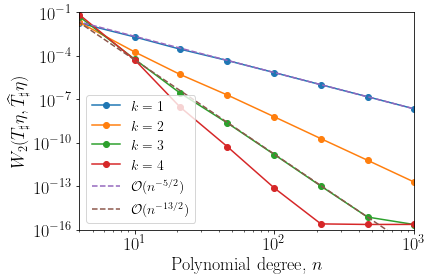

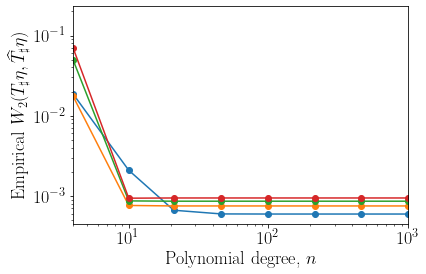

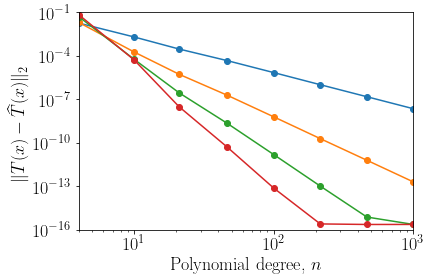

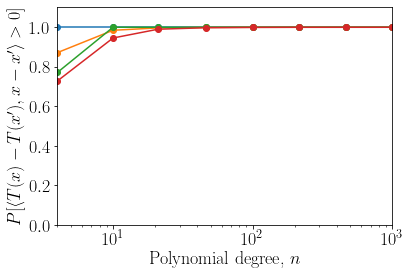

In [15]:
conv=pickle.load(open('data/W2compact_polydisc_mon.p','rb'))
Wp_loss = conv['Wp']
L2_test_error = conv['L2']
mon_percent = conv['Mon']

plt.figure()
for (j,k) in enumerate(k_vect):
    plt.loglog(orders, Wp_loss[j,:], '-o', label='$k = '+str(k)+'$')
plt.loglog(orders, Wp_loss[0,-1]/(orders/orders[-1])**(2.5), '--', label='$\mathcal{O}(n^{-5/2})$')
plt.loglog(orders, Wp_loss[-2,-2]/(orders/orders[-2])**(6.5), '--', label='$\mathcal{O}(n^{-13/2})$')
plt.xlabel('Polynomial degree, $n$')
plt.ylabel('$W_2(T_\sharp \eta, \widehat{T}_\sharp \eta)$')
plt.xlim(4,1000)
plt.ylim(1e-16,1e-1)
plt.legend(fontsize=14)
plt.savefig('figures/W2compact_Wp_poly.pdf',bbox_inches="tight")

plt.figure()
for (j,k) in enumerate(k_vect):
    plt.loglog(orders, Wp_emp[j,:], '-o')
plt.xlabel('Polynomial degree, $n$')
plt.ylabel('Empirical $W_2(T_\sharp \eta, \widehat{T}_\sharp \eta)$')
plt.xlim(4,1000)
#plt.ylim(1e-16,1e-1)
plt.savefig('figures/W2compact_Wp_poly.pdf',bbox_inches="tight")

plt.figure()
for (j,k) in enumerate(k_vect):
    plt.loglog(orders, L2_test_error[j,:], '-o')
plt.xlabel('Polynomial degree, $n$')
plt.ylabel('$\|T(x) - \widehat T(x)\|_{2}$')
plt.xlim(4,1000)
plt.ylim(1e-16,1e-1)
plt.savefig('figures/W2compact_L2_poly.pdf',bbox_inches="tight")

plt.figure()
for (j,k) in enumerate(k_vect):
    plt.semilogx(orders, mon_percent[j,:], '-o')
plt.xlabel('Polynomial degree, $n$')
plt.ylabel('$P[\\langle T(x) - T(x\'), x - x\' \\rangle > 0]$')
plt.xlim(4,1000)
plt.ylim(0,1.1)
plt.savefig('figures/W2compact_monotonicity_poly.pdf',bbox_inches="tight")

In [14]:
# create table with results
power = [5./2., 8./2., 13./2., 13./2.]
for (j,k) in enumerate(k_vect):
    print('k = '+str(k))
    for (i,order) in enumerate(orders):
        print('$'+str(order), end ="$ & ")
    print('\\\\')
    print('$W_2(\pi,\hat\pi)$', end=' & ')
    for (i,order) in enumerate(orders):
        print('$ %1.2e' % (Wp_loss[j,i]), end ="$ & ")
    print('\\\\')
    print('$\|T - \hat T\|_{L^2_\eta}$', end=' & ')
    for (i,order) in enumerate(orders):
        print('$ %1.2e' % (L2_test_error[j,i]), end ="$ & ")
    print('\\\\')
    print('$O(n^{-5/2}$', end=' & ')
    rescaled_Wp_loss = Wp_loss[j,-3]/(orders/orders[-3])**power[j]
    for (i,order) in enumerate(orders):
        print('$ %1.2e' % (rescaled_Wp_loss[i]), end ="$ & ")
    print('\\\\')

k = 1
$1$ & $2$ & $4$ & $10$ & $21$ & $46$ & $100$ & $215$ & $464$ & $1000$ & \\
$W_2(\pi,\hat\pi)$ & $ 1.12e-01$ & $ 1.12e-01$ & $ 1.86e-02$ & $ 2.04e-03$ & $ 2.98e-04$ & $ 4.84e-05$ & $ 7.05e-06$ & $ 1.03e-06$ & $ 1.53e-07$ & $ 2.25e-08$ & \\
$\|T - \hat T\|_{L^2_\eta}$ & $ 1.12e-01$ & $ 1.12e-01$ & $ 1.86e-02$ & $ 2.04e-03$ & $ 2.99e-04$ & $ 4.85e-05$ & $ 7.09e-06$ & $ 1.04e-06$ & $ 1.54e-07$ & $ 2.28e-08$ & \\
$O(n^{-5/2}$ & $ 7.01e-01$ & $ 1.24e-01$ & $ 2.19e-02$ & $ 2.22e-03$ & $ 3.47e-04$ & $ 4.89e-05$ & $ 7.01e-06$ & $ 1.03e-06$ & $ 1.51e-07$ & $ 2.22e-08$ & \\
k = 2
$1$ & $2$ & $4$ & $10$ & $21$ & $46$ & $100$ & $215$ & $464$ & $1000$ & \\
$W_2(\pi,\hat\pi)$ & $ 1.67e-01$ & $ 1.67e-01$ & $ 2.08e-02$ & $ 1.86e-04$ & $ 5.40e-06$ & $ 2.02e-07$ & $ 6.25e-09$ & $ 1.98e-10$ & $ 6.36e-12$ & $ 2.01e-13$ & \\
$\|T - \hat T\|_{L^2_\eta}$ & $ 1.67e-01$ & $ 1.67e-01$ & $ 2.09e-02$ & $ 1.86e-04$ & $ 5.41e-06$ & $ 2.02e-07$ & $ 6.28e-09$ & $ 1.98e-10$ & $ 6.38e-12$ & $ 2.03e-13$ & \\
$O(n^{